In [49]:
import numpy as np
import pandas as pd
import seaborn
import matplotlib.pyplot as plt
import datetime
import csv
import os
from sklearn.metrics import r2_score, mean_squared_error
pd.options.display.max_rows = 99

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from modules.prediction import load_all_data
from modules.prediction import precrime_train_test_split
from modules.prediction import load_splits
from modules.prediction import create_all_splits
from modules.prediction import sample_model
from modules.poly_ridge import poly_ridge_model
from modules.fancy_time_series import fancy_time_series_model
from modules.eval_model import eval_predictions


In [3]:
crime_data = load_all_data()

/Users/jsamet/anaconda/lib/python3.6/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
from modules.prediction import create_test_period

In [5]:
split_all_2017 = create_test_period(datetime.date(2017,1,1),datetime.date(2017,10,1))
split_thru_june_2017 = create_test_period(datetime.date(2017,1,1),datetime.date(2017,7,1))

In [6]:
train_test_data = create_all_splits(crime_data, {'all_2017': split_all_2017})

In [7]:
X_train_2017, X_test_2017, y_train_2017, y_test_2017 = train_test_data['all_2017']

In [8]:
y_poly_2017 = poly_ridge_model(X_train_2017, y_train_2017, X_test_2017)
y_ts_2017 = fancy_time_series_model(X_train_2017, y_train_2017, X_test_2017, y_test_2017)
y_hybrid_2017 = (y_poly_2017 + y_ts_2017) / 2

In [9]:
eval_predictions(X_test_2017, y_test_2017, y_hybrid_2017)

------------------------------------------------------------------
Four-hour buckets:
------------------------------------------------------------------
Homicide:         R2 =     -0.4, RMSE =     0.041, RMSE (%) =  2730.391
Rape:             R2 =      0.0, RMSE =     0.112, RMSE (%) =   918.150
Robbery:          R2 =      3.7, RMSE =     0.291, RMSE (%) =   358.580
FelonyAssault:    R2 =      5.4, RMSE =     0.382, RMSE (%) =   318.653
Burglary:         R2 =      1.0, RMSE =     0.269, RMSE (%) =   391.755
GrandLarceny:     R2 =     10.7, RMSE =     0.501, RMSE (%) =   213.885
GrandLarcenyAuto: R2 =      1.4, RMSE =     0.183, RMSE (%) =   562.755
Fraud:            R2 =      1.7, RMSE =     0.152, RMSE (%) =   675.712
Forgery:          R2 =      2.6, RMSE =     0.181, RMSE (%) =   586.003
Arson:            R2 =     -0.4, RMSE =     0.065, RMSE (%) =  1623.359
Drugs:            R2 =      2.8, RMSE =     0.168, RMSE (%) =   623.468
Weapons:          R2 =      3.2, RMSE =     0.174, RMSE

In [10]:
crime_data.head()

,COMPLAINT_YEAR,COMPLAINT_MONTH,COMPLAINT_DAY,COMPLAINT_HOURGROUP,ADDR_PCT_CD,COMPLAINT_DAYOFWEEK,apparentTemperature,cloudCover,dewPoint,humidity,...,GrandLarceny,GrandLarcenyAuto,Fraud,Forgery,Arson,Drugs,Weapons,CriminalMischief,Other,COMPLAINT_IDS
0,2006,1,2,0,1,0,34.61,0.24,31.26,0.78,...,0,0,0,0,0,0,0,0,0,
1,2006,1,2,0,5,0,34.61,0.24,31.26,0.78,...,0,0,0,0,0,0,0,0,0,
2,2006,1,2,0,6,0,34.61,0.24,31.26,0.78,...,1,0,0,0,0,0,0,1,0,218039893 236109607
3,2006,1,2,0,7,0,34.61,0.24,31.26,0.78,...,0,0,0,0,0,0,0,0,0,
4,2006,1,2,0,9,0,34.61,0.24,31.26,0.78,...,1,0,0,0,0,0,0,0,0,886457370


In [11]:
offense_types = [x for x in y_train_2017.select_dtypes(exclude=['object']).columns]

In [12]:
key_fields = [
    'COMPLAINT_YEAR',
    'COMPLAINT_MONTH',
    'COMPLAINT_DAY',
    'COMPLAINT_HOURGROUP',
    'ADDR_PCT_CD',
]

In [21]:
monthly_means = crime_data.groupby([
    'COMPLAINT_YEAR',
    'COMPLAINT_MONTH',
    'ADDR_PCT_CD'
]).sum().reset_index().groupby('ADDR_PCT_CD')[offense_types].mean()

In [24]:
demographics_by_precinct = crime_data[[
    'ADDR_PCT_CD',
    'Population',
    'Median_Household_Income',
    'Percent_Bachelors_Degree'
]].groupby(['ADDR_PCT_CD']).mean()

In [44]:
X = demographics_by_precinct[demographics_by_precinct.index != 22]
y = monthly_means[monthly_means.index != 22]
y_per_100k = pd.DataFrame(index=y.index.copy())
for c in offense_types:
    y_per_100k[c] = 100000 * pd.Series(y[c] / X['Population'], index = y_per_100k.index)

In [162]:
y_per_100k

,Homicide,Rape,Robbery,FelonyAssault,Burglary,GrandLarceny,GrandLarcenyAuto,Fraud,Forgery,Arson,Drugs,Weapons,CriminalMischief,Other
ADDR_PCT_CD,,,,,,,,,,,,,,
1,0.112846,2.185118,10.792225,10.433168,20.630384,134.482198,5.457665,8.771247,10.935847,0.553974,1.323381,2.246670,7.027257,8.709695
5,0.237524,2.542908,18.568820,25.065812,19.225506,92.522746,3.632726,3.898195,16.095772,1.341314,2.892209,3.674642,10.213550,22.844260
6,0.152425,2.532603,20.870523,15.664617,25.138428,153.925971,5.968032,8.488909,5.416956,0.281400,8.641335,3.798904,13.096840,8.207509
7,0.233109,2.576464,21.261962,18.292894,12.330220,51.075330,6.195782,4.024191,5.410574,1.656298,11.925347,6.563849,7.226368,15.053911
9,0.212565,2.726382,18.973773,16.995991,21.053218,90.266364,6.044251,9.306668,4.362212,1.053585,9.620895,5.637604,5.591394,11.728065
10,0.242227,2.852896,19.378164,18.826425,16.283041,115.972931,7.239898,10.779104,6.890014,1.116936,9.150800,7.307183,8.491404,11.519242
13,0.157296,3.310713,16.186542,14.284006,23.781708,131.851783,4.966070,11.557536,7.295554,0.599224,3.625306,3.969860,6.299344,7.759953
14,0.786216,12.695926,70.409977,62.198392,127.046622,803.803564,8.677491,23.149682,95.015615,1.048288,23.819422,21.227822,43.241860,51.511683
17,0.078790,1.900800,7.908510,7.563805,14.132891,88.795920,3.575080,8.745650,4.097061,0.177277,0.945476,0.620468,6.017558,4.451614


In [78]:
y_per_100k_normalized = y_per_100k / y_per_100k.mean()

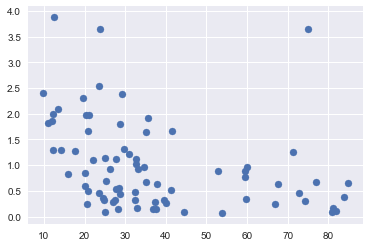

In [79]:
plt.scatter(X['Percent_Bachelors_Degree'], y_per_100k_normalized['Weapons'])

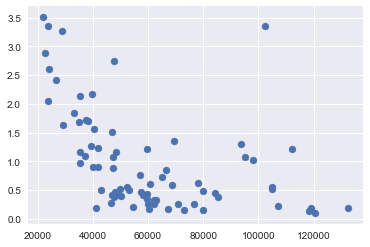

In [80]:
plt.scatter(X['Median_Household_Income'], y_per_100k_normalized['Drugs'])

In [50]:
y_per_100k_normalized

,Homicide,Rape,Robbery,FelonyAssault,Burglary,GrandLarceny,GrandLarcenyAuto,Fraud,Forgery,Arson,Drugs,Weapons,CriminalMischief,Other
ADDR_PCT_CD,,,,,,,,,,,,,,
1,0.243855,0.836967,0.514592,0.502794,1.051561,2.384151,0.599968,1.506412,1.668385,0.395243,0.186778,0.385012,0.844879,0.595158
5,0.513277,0.974012,0.885393,1.207969,0.979952,1.640278,0.399350,0.669493,2.455588,0.956986,0.408197,0.629723,1.227963,1.561012
6,0.329382,0.970065,0.995142,0.754908,1.281342,2.728858,0.656073,1.457922,0.826417,0.200770,1.219611,0.651018,1.574618,0.560842
7,0.503735,0.986865,1.013807,0.881569,0.628489,0.905483,0.681110,0.691132,0.825443,1.181717,1.683106,1.124846,0.868818,1.028676
9,0.459342,1.044288,0.904702,0.819069,1.073113,1.600276,0.664452,1.598368,0.665504,0.751700,1.357863,0.966116,0.672247,0.801411
10,0.523439,1.092747,0.923984,0.907281,0.829970,2.056012,0.795891,1.851251,1.051148,0.796899,1.291515,1.252231,1.020912,0.787142
13,0.339909,1.268105,0.771802,0.688373,1.212188,2.337518,0.545926,1.984942,1.113018,0.427528,0.511664,0.680315,0.757363,0.530259
14,1.698969,4.862930,3.357268,2.997459,6.475751,14.250135,0.953927,3.975828,14.495684,0.747920,3.361798,3.637810,5.198918,3.519937
17,0.170260,0.728065,0.377091,0.364514,0.720374,1.574208,0.393013,1.502016,0.625052,0.126481,0.133441,0.106330,0.723484,0.304191


In [82]:
X_test_2017.head()

,COMPLAINT_YEAR,COMPLAINT_MONTH,COMPLAINT_DAY,COMPLAINT_HOURGROUP,ADDR_PCT_CD,COMPLAINT_DAYOFWEEK,apparentTemperature,cloudCover,dewPoint,humidity,...,time,uvIndex,visibility,windBearing,windGust,windSpeed,PrecinctShapefileID,Population,Median_Household_Income,Percent_Bachelors_Degree
1855854,2017,1,1,0,1,6,39.19,0.31,26.72,0.49,...,1483254000,NaN,10.0,253.0,NaN,11.61,0,69133.039371,132330.083503,83.828412
1855855,2017,1,1,0,5,6,39.19,0.31,26.72,0.49,...,1483254000,NaN,10.0,253.0,NaN,11.61,1,50759.992787,49552.406674,37.904058
1855856,2017,1,1,0,6,6,39.19,0.31,26.72,0.49,...,1483254000,NaN,10.0,253.0,NaN,11.61,2,60487.767154,112107.491675,84.791603
1855857,2017,1,1,0,7,6,39.19,0.31,26.72,0.49,...,1483254000,NaN,10.0,253.0,NaN,11.61,3,57806.426169,34945.568718,32.632376
1855858,2017,1,1,0,9,6,39.19,0.31,26.72,0.49,...,1483254000,NaN,10.0,253.0,NaN,11.61,4,76738.998728,69325.458794,59.913145


In [118]:
data_2017 = pd.merge(X_test_2017, y_test_2017, left_index=True, right_index=True)[
    key_fields + offense_types + ['COMPLAINT_DAYOFWEEK']
]

In [138]:
data_with_predictions_2017 = pd.merge(
    data_2017,
    y_hybrid_2017,
    left_index=True,
    right_index=True,
    suffixes=['','_Predicted']
).groupby([
    'COMPLAINT_YEAR',
    'COMPLAINT_MONTH',
    'COMPLAINT_DAY',
    'COMPLAINT_HOURGROUP'
])[offense_types + ['{0}_Predicted'.format(x) for x in offense_types]].sum()

In [244]:
import matplotlib.dates as mdates
import imageio

def make_timeseries_pngs(data, offense):
    myFmt = mdates.DateFormatter('%b %d %I %p')
    offense_predicted = '{0}_Predicted'.format(offense)
    portion = data[[offense, offense_predicted]]
    portion_columns = portion.reset_index()[[
        'COMPLAINT_YEAR',
        'COMPLAINT_MONTH',
        'COMPLAINT_DAY',
        'COMPLAINT_HOURGROUP'
    ]]
    portion_columns['year'] = portion_columns['COMPLAINT_YEAR']
    portion_columns['month'] = portion_columns['COMPLAINT_MONTH']
    portion_columns['day'] = portion_columns['COMPLAINT_DAY']
    portion_columns['hour'] = portion_columns['COMPLAINT_HOURGROUP'] + 2
    portion_columns['datetime'] = pd.to_datetime(portion_columns[[
        'year', 'month', 'day', 'hour'
    ]])

    filenames, images = [], []
    for start_idx in range(0, len(portion_columns), 4):
        fig, ax = plt.subplots(figsize=(18,12))
        ax.plot(portion_columns['datetime'][start_idx:start_idx+84], portion[offense][start_idx:start_idx+84], label='{0} (Actual)'.format(offense))
        ax.plot(portion_columns['datetime'][start_idx:start_idx+84], portion[offense_predicted][start_idx:start_idx+84], label='{0} (Predicted)'.format(offense))
        ax.legend(loc=1)
        ax.set_xticks(portion_columns['datetime'][start_idx:start_idx+84].values[::4])
        ax.set_xticklabels(portion_columns['datetime'][start_idx:start_idx+84][::4], rotation='vertical', fontsize=14)
        ax.xaxis.set_major_formatter(myFmt)
        filenames.append('../precrime_data/images/{0}_frame{1:04d}.png'.format(offense, int(start_idx/4)))
        fig.savefig(filenames[-1])
        plt.close(fig)
        if start_idx % 100 == 0:
            print('made frame {0:04d} for {1}'.format(start_idx, offense))


In [245]:
for o in offense_types:
    make_timeseries_pngs(data_with_predictions_2017, o)

made frame 0000 for Homicide
made frame 0100 for Homicide
made frame 0200 for Homicide
made frame 0300 for Homicide
made frame 0400 for Homicide
made frame 0500 for Homicide
made frame 0600 for Homicide
made frame 0700 for Homicide
made frame 0800 for Homicide
made frame 0900 for Homicide
made frame 1000 for Homicide
made frame 1100 for Homicide
made frame 1200 for Homicide
made frame 1300 for Homicide
made frame 1400 for Homicide
made frame 1500 for Homicide
made frame 1600 for Homicide
made frame 0000 for Rape
made frame 0100 for Rape
made frame 0200 for Rape
made frame 0300 for Rape
made frame 0400 for Rape
made frame 0500 for Rape
made frame 0600 for Rape
made frame 0700 for Rape
made frame 0800 for Rape
made frame 0900 for Rape
made frame 1000 for Rape
made frame 1100 for Rape
made frame 1200 for Rape
made frame 1300 for Rape
made frame 1400 for Rape
made frame 1500 for Rape
made frame 1600 for Rape
made frame 0000 for Robbery
made frame 0100 for Robbery
made frame 0200 for Robber

In [180]:
len(data_with_predictions_2017)/12

136.5

In [143]:
portion_columns

,COMPLAINT_YEAR,COMPLAINT_MONTH,COMPLAINT_DAY,COMPLAINT_HOURGROUP,Weapons,Weapons_Predicted
0,2017,1,1,0,6,4.129841
1,2017,1,1,4,1,1.123803
2,2017,1,1,8,0,0.703786
3,2017,1,1,12,0,1.014071
4,2017,1,1,16,1,1.680137
5,2017,1,1,20,1,1.798921
6,2017,1,2,0,2,1.029662
7,2017,1,2,4,0,0.843306
8,2017,1,2,8,0,0.817389
9,2017,1,2,12,1,1.680591


In [129]:
data_with_predictions_precinct_2017 = pd.merge(
    data_2017,
    y_hybrid_2017,
    left_index=True,
    right_index=True,
    suffixes=['','_Predicted']
).groupby([
    'COMPLAINT_YEAR',
    'COMPLAINT_MONTH',
    'ADDR_PCT_CD'
])[offense_types + ['{0}_Predicted'.format(x) for x in offense_types]].sum()


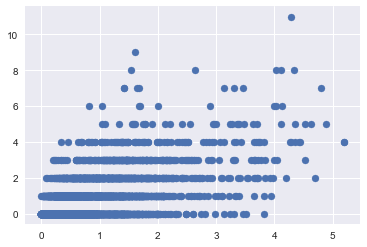

In [124]:
plt.scatter(
    data_with_predictions_precinct_2017['Weapons_Predicted'],
    data_with_predictions_precinct_2017['Weapons'],
)

In [233]:
from scipy.stats import gaussian_kde
def make_scatterplot(data, offense):
    x1, y1 = data['{0}_Predicted'.format(offense)].values, data[offense].values
    xy = np.vstack([x1,y1,])
    z = gaussian_kde(xy)(xy)

    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x2, y2, z2 = x1[idx], y1[idx], z[idx]

    fig, ax = plt.subplots(figsize=(12,12))
    ax.scatter(x2, y2, c=z2, s=50, edgecolor='', cmap='viridis')
    ax.set_xlabel('Predicted Number of Offenses', fontsize=14)
    ax.set_ylabel('Actual Number of Offenses', fontsize=14)
    ax.set_title('{0} Offenses By Precinct and Month'.format(offense), fontsize=16)
    fig.savefig('../precrime_data/images/{0}_scatter.png'.format(offense))

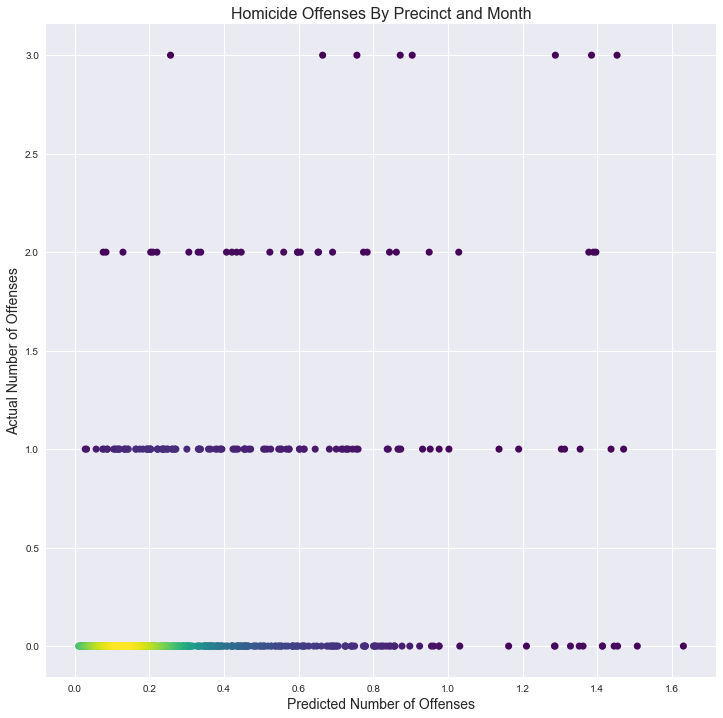

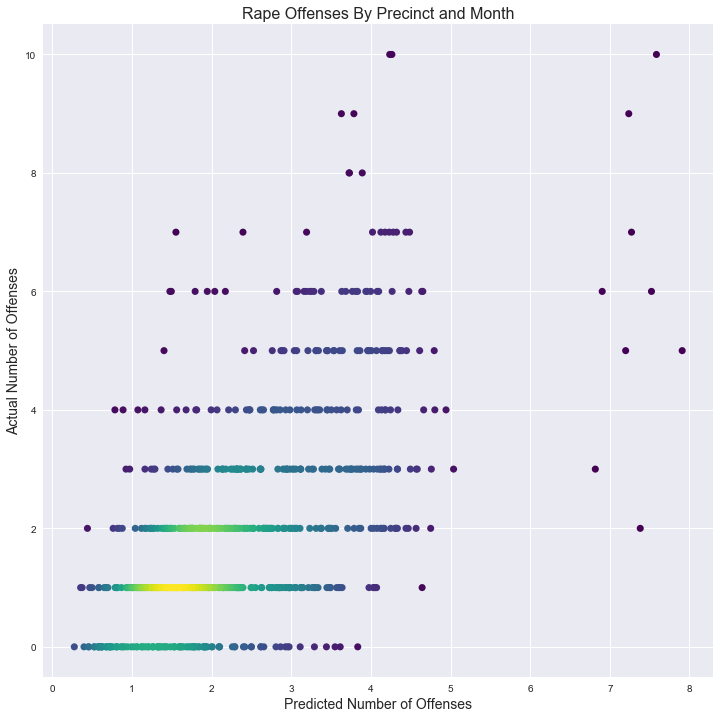

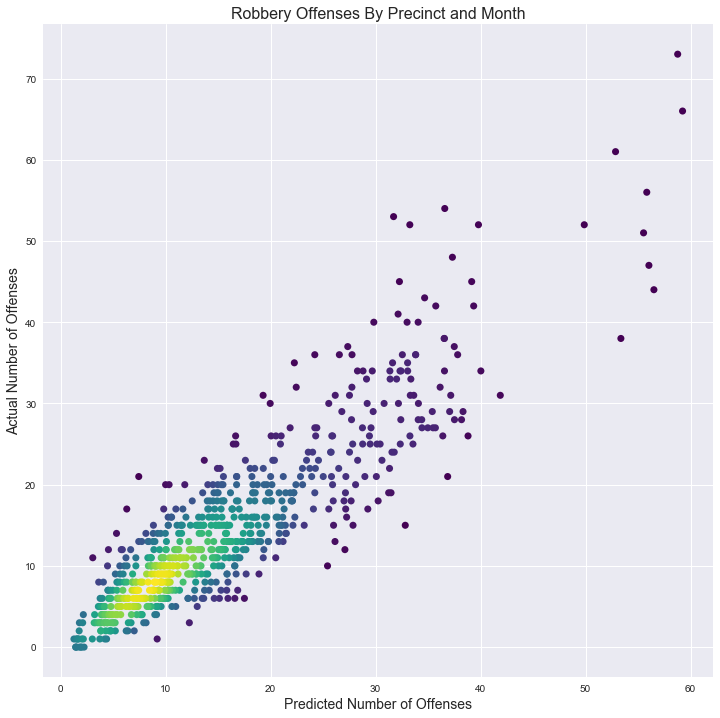

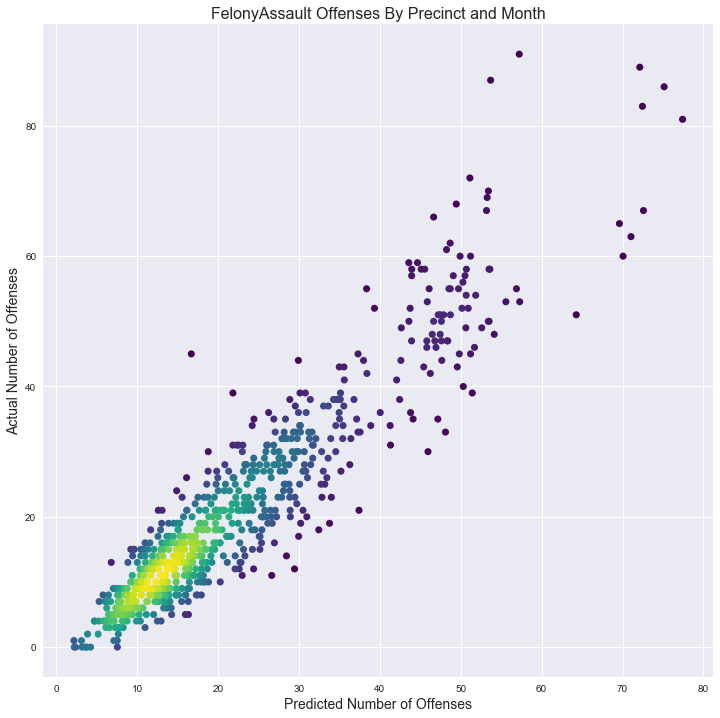

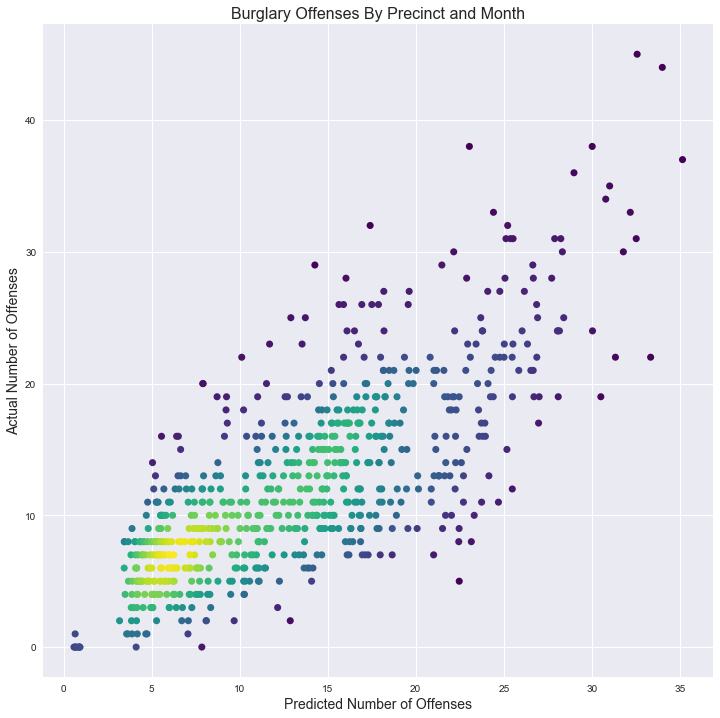

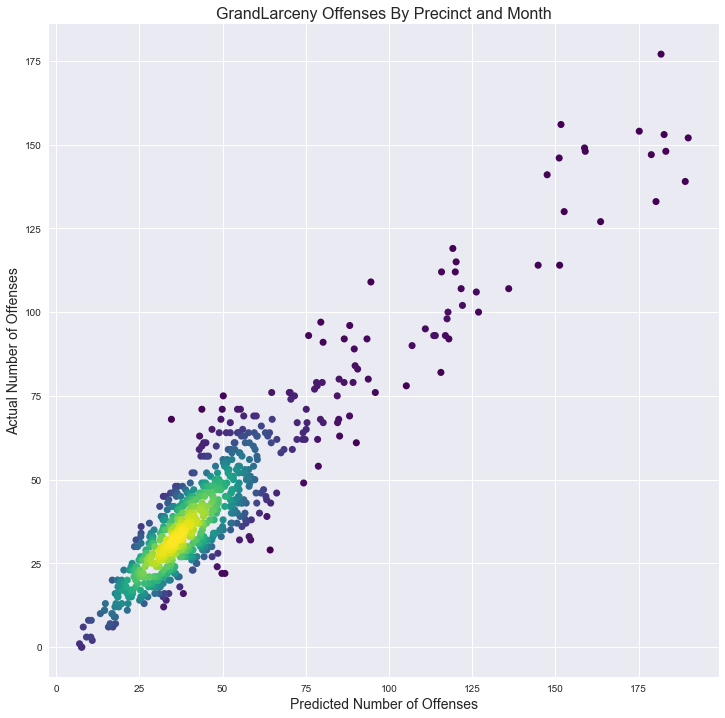

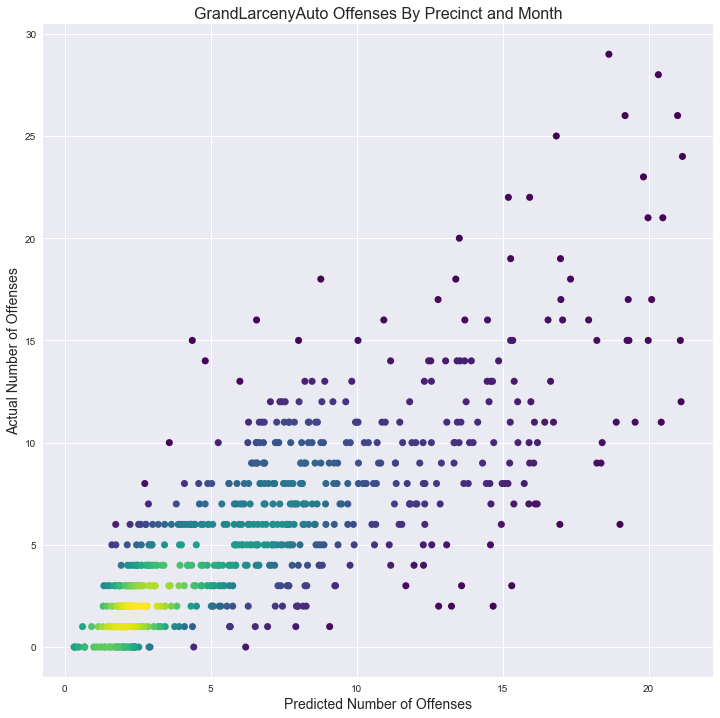

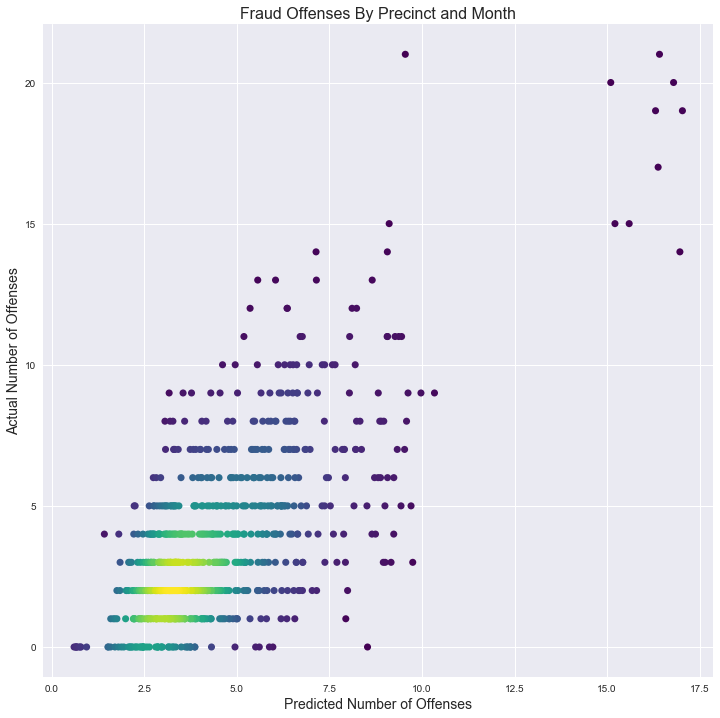

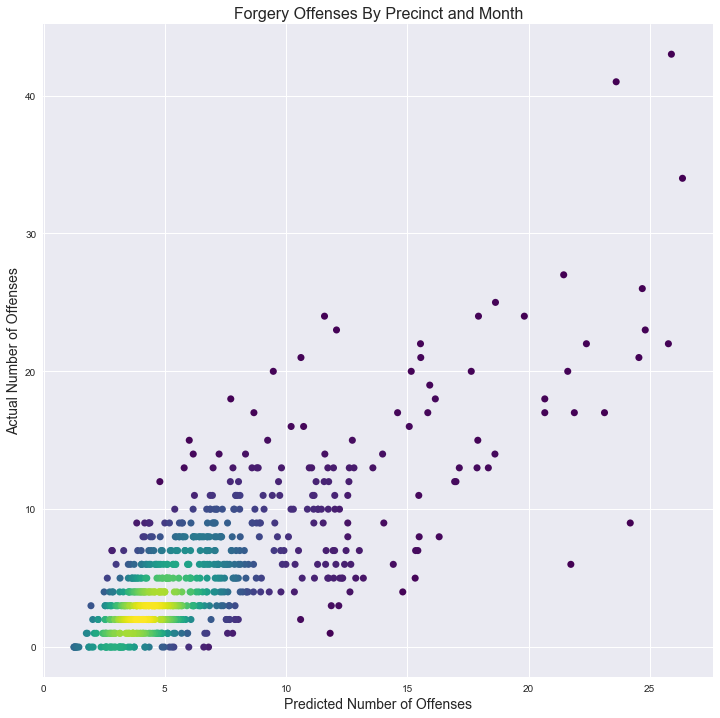

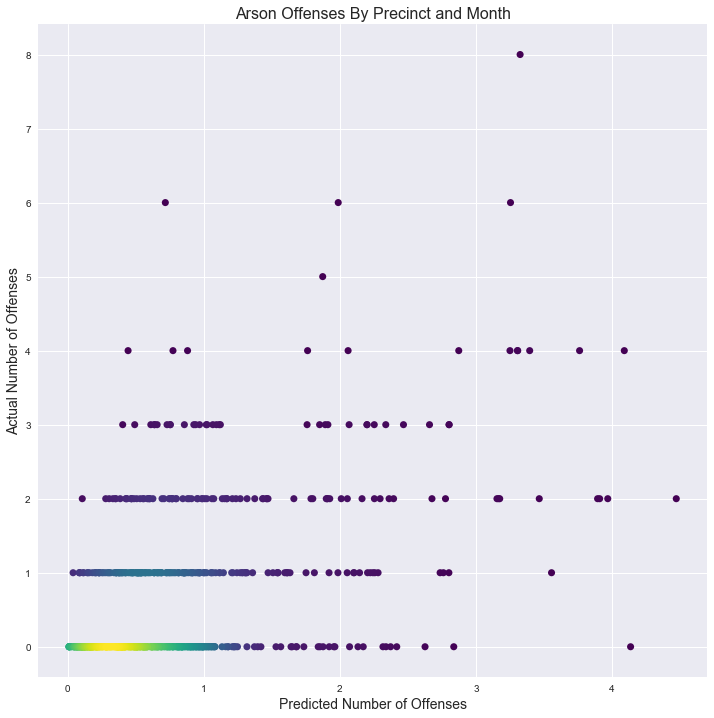

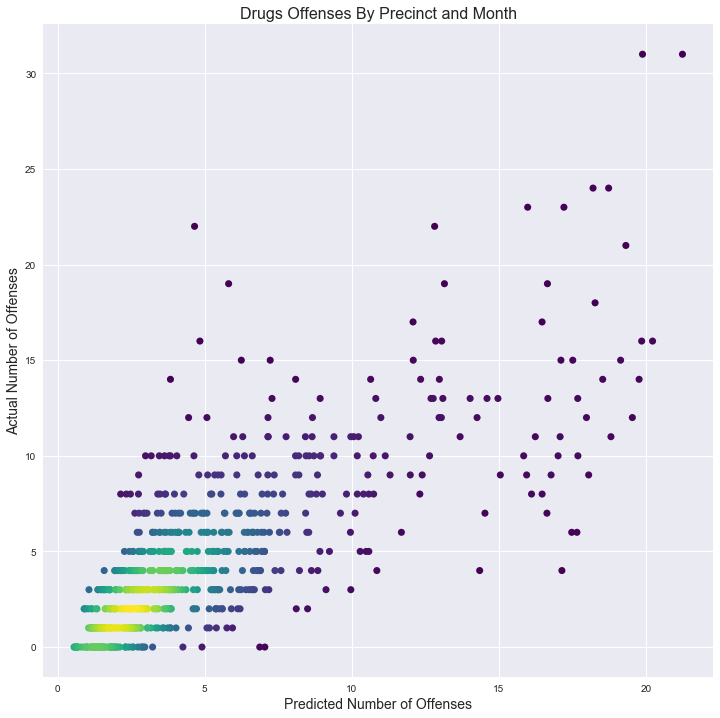

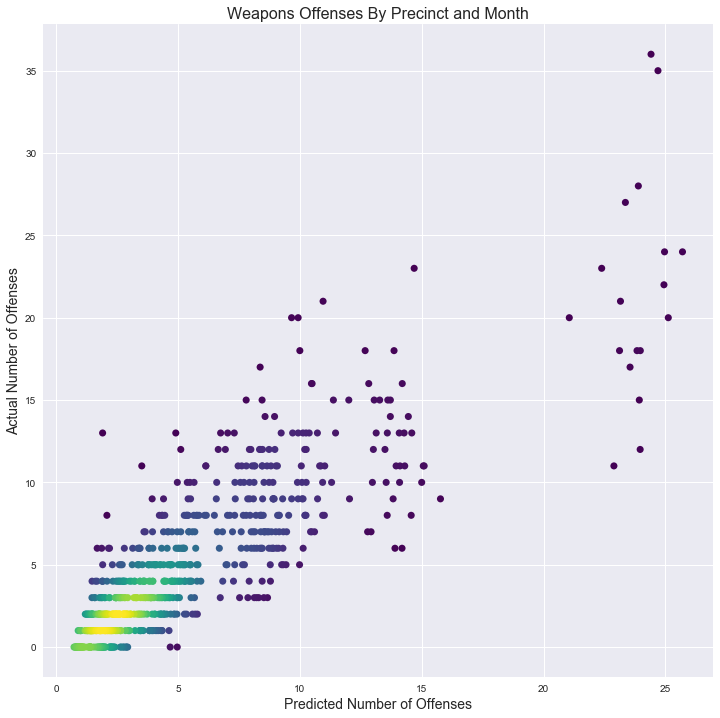

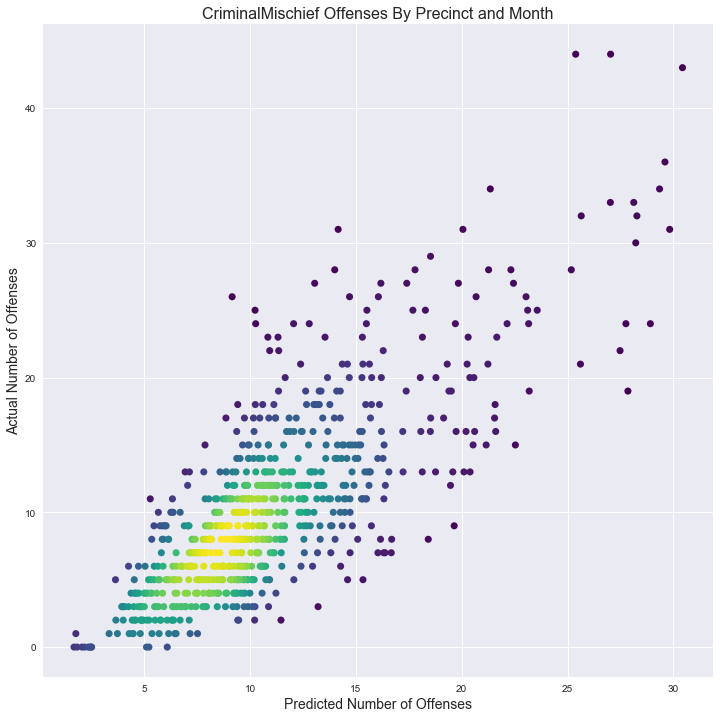

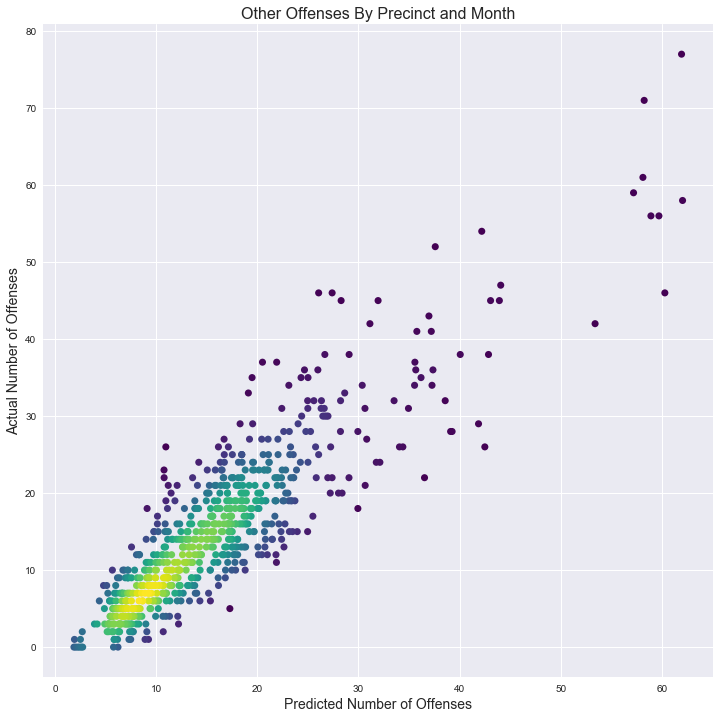

In [235]:
for o in offense_types:
    make_scatterplot(data_with_predictions_precinct_2017, o)

In [247]:
for o in offense_types:
    print('ffmpeg -n -framerate 8 -i "{0}_frame%04d.png" ../movies/{0}.mp4'.format(o))

ffmpeg -n -framerate 8 -i "Homicide_frame%04d.png" ../movies/Homicide.mp4
ffmpeg -n -framerate 8 -i "Rape_frame%04d.png" ../movies/Rape.mp4
ffmpeg -n -framerate 8 -i "Robbery_frame%04d.png" ../movies/Robbery.mp4
ffmpeg -n -framerate 8 -i "FelonyAssault_frame%04d.png" ../movies/FelonyAssault.mp4
ffmpeg -n -framerate 8 -i "Burglary_frame%04d.png" ../movies/Burglary.mp4
ffmpeg -n -framerate 8 -i "GrandLarceny_frame%04d.png" ../movies/GrandLarceny.mp4
ffmpeg -n -framerate 8 -i "GrandLarcenyAuto_frame%04d.png" ../movies/GrandLarcenyAuto.mp4
ffmpeg -n -framerate 8 -i "Fraud_frame%04d.png" ../movies/Fraud.mp4
ffmpeg -n -framerate 8 -i "Forgery_frame%04d.png" ../movies/Forgery.mp4
ffmpeg -n -framerate 8 -i "Arson_frame%04d.png" ../movies/Arson.mp4
ffmpeg -n -framerate 8 -i "Drugs_frame%04d.png" ../movies/Drugs.mp4
ffmpeg -n -framerate 8 -i "Weapons_frame%04d.png" ../movies/Weapons.mp4
ffmpeg -n -framerate 8 -i "CriminalMischief_frame%04d.png" ../movies/CriminalMischief.mp4
ffmpeg -n -framerate